### Project: Analyze fluctuations in HTTP request latency data to determine reliability

Appendix:
- Prepare data:
	- Create sample data from script (data has interval time is 30 second)
- Analyze data
	- Load data (.csv) to dataframe
	- Standardize data
	    - Set index for dataframe is timestamp
	- Explore data
	    - Overview dataset by summary buckets in time series
        - Analyze fluctuations on the dataset
        - Identify issue about latency http request on dataset -> Result about time range issue occur
    - SLI Calculator
        - Simulator rate() on rolling windows
        - Calculate percentile: [50th, 90th, 95th, 99th] or latency in time vector
	
- Apply model

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [2]:
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2]

In [3]:
# Load dataset from CSV file
root = pd.read_csv('../statics/csv/request_data_with_anomaly_pod_instance.csv', index_col=0)

In [36]:
# Convert to datetime pandas and set datetime columns is index for dataframe
root.index = pd.to_datetime(root.index)
root

,path,method,service_name,controller_pod,0.005,0.01,0.025,0.05,0.1,0.25,0.5,1,2,+Inf
timestamp,,,,,,,,,,,,,,
2024-01-02 10:42:00,/home,GET,process_log,pod-1,0,0,0,0,0,1,1,1,1,1
2024-01-02 10:42:00,/home,GET,process_log,pod-2,0,0,0,0,0,0,1,2,2,2
2024-01-02 10:42:00,/users,GET,process_log,pod-1,0,0,0,0,1,2,3,5,5,5
2024-01-02 10:42:00,/users,GET,process_log,pod-2,0,0,0,0,0,0,2,3,3,3
2024-01-02 10:42:30,/home,GET,process_log,pod-1,0,0,0,0,1,8,12,21,21,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-02 14:37:30,/home,GET,process_log,pod-2,0,12,187,487,1071,2733,5566,8866,8866,8866
2024-01-02 14:37:30,/users,GET,process_log,pod-1,0,8,148,394,914,2501,4997,8166,8847,8847
2024-01-02 14:37:30,/users,GET,process_log,pod-2,0,5,188,452,1022,2638,5355,8694,8694,8694


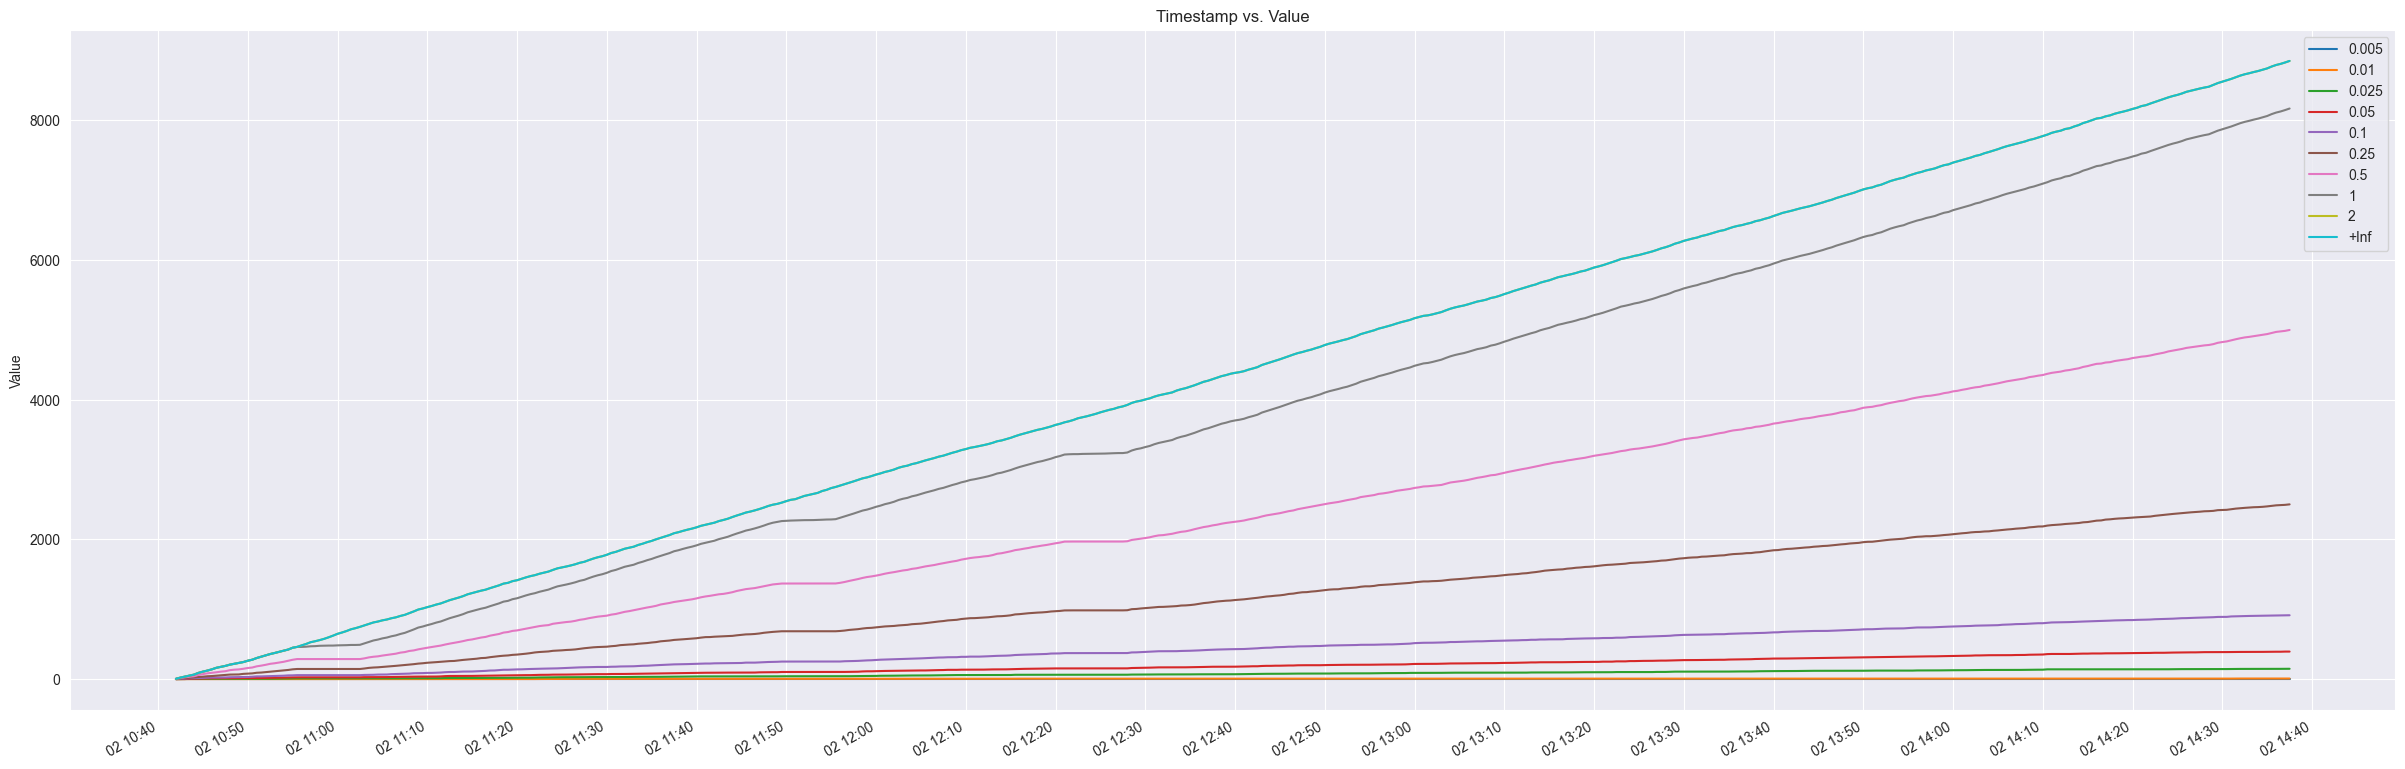

In [51]:
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
chart_data = root.query("path == '/users' and controller_pod == 'pod-1'")
plt.figure(figsize=(30, 10))
# Configure x-axis date ticks
locator = AutoDateLocator(minticks=5, maxticks=30)
formatter = AutoDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
for column in BUCKETS + ["+Inf"]:
    plt.plot(chart_data.index, chart_data[str(column)],linestyle='-', label=column)
    plt.legend()
plt.ylabel('Value')
plt.title('Timestamp vs. Value')
plt.gcf().autofmt_xdate()
plt.show()

In [6]:
grouped = ['service_name', 'controller_pod', 'path', 'method']